In [62]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Imports

In [95]:
from __future__ import print_function, division

from collections import deque, namedtuple
from itertools import product
from time import time
import datetime

from tqdm import tqdm

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization, Input, Bidirectional, GRU
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from keras.utils import plot_model

from keras.optimizers import Adam

import numpy as np
import pandas as pd
import os
import math
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
plt.rcParams['figure.figsize'] = [10, 6]
sns.set_style("darkgrid")
%matplotlib notebook

In [65]:
np.random.seed(7)

### VectorNav Data

In [3]:
groundTruth = pd.read_csv('./aug22/vectornav.csv')
groundTruth.head()

,%time,field.header.seq,field.header.stamp,field.header.frame_id,field.Time,field.Week,field.Status,field.RPY.x,field.RPY.y,field.RPY.z,...,field.NedVel.x,field.NedVel.y,field.NedVel.z,field.YawUncertainty,field.PitchUncertainty,field.RollUncertainty,field.PosUncertainty,field.VelUncertainty,field.SyncInTime,field.SyncInCount
0,1534964283759583733,148534,1534964283759488543,ins,1.219000e+09,2015,774,-0.206582,-1.139857,-80.660164,...,0.386322,-3.760047,0.026968,0.313101,0.060608,0.060775,0.434633,0.068759,1.534960e+09,0
1,1534964283779652145,148535,1534964283779410964,ins,1.219000e+09,2015,774,-0.198399,-1.140850,-80.806984,...,0.372377,-3.753964,0.036528,0.313183,0.060686,0.060855,0.435148,0.069070,1.534960e+09,0
2,1534964283799706637,148536,1534964283799478607,ins,1.219000e+09,2015,33542,-0.197157,-1.158168,-80.955826,...,0.357988,-3.751092,0.046906,0.313264,0.060764,0.060934,0.435667,0.069383,1.534960e+09,0
3,1534964283819496468,148537,1534964283819370247,ins,1.219000e+09,2015,33542,-0.191352,-1.181736,-81.107323,...,0.346980,-3.753714,0.054115,0.313346,0.060842,0.061014,0.436190,0.069696,1.534960e+09,0
4,1534964283839574407,148538,1534964283839416560,ins,1.219000e+09,2015,33542,-0.190564,-1.205545,-81.259956,...,0.337809,-3.763550,0.056818,0.313427,0.060920,0.061093,0.436717,0.070010,1.534960e+09,0


In [4]:
gt = groundTruth[['field.RPY.x',
 'field.RPY.y',
 'field.RPY.z']]

gt.head()

,field.RPY.x,field.RPY.y,field.RPY.z
0,-0.206582,-1.139857,-80.660164
1,-0.198399,-1.140850,-80.806984
2,-0.197157,-1.158168,-80.955826
3,-0.191352,-1.181736,-81.107323
4,-0.190564,-1.205545,-81.259956


In [9]:
baseline = gt.iloc[0,2]

/home/ankurrc/.conda/envs/fastai-cpu/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


<IPython.core.display.Javascript object>


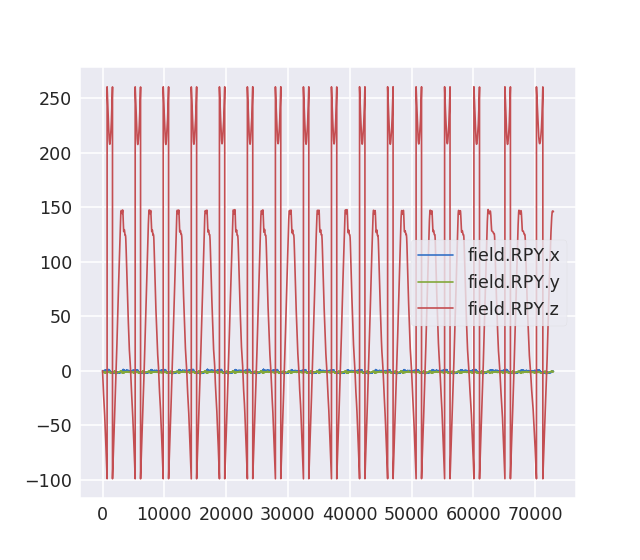

In [11]:
gt.loc[:, 'field.RPY.z'] = gt["field.RPY.z"] - baseline
gt.plot()

In [14]:
gt.describe()

,field.RPY.x,field.RPY.y,field.RPY.z
count,72971.000000,72971.000000,72971.000000
mean,-0.680080,-1.461639,75.774875
std,0.874738,0.451816,102.990893
min,-2.408524,-2.865238,-99.338448
25%,-1.561786,-1.778289,-15.367680
50%,-0.401902,-1.403264,78.476702
75%,0.022367,-1.162422,145.071796
max,1.204640,-0.393468,260.654655


In [15]:
# gt[['field.RPY.z']] = gt[['field.RPY.z']]
gtNew = gt.copy(deep=True)
yawAngles = gtNew['field.RPY.z'].values
# yawNew = yawAngles

<IPython.core.display.Javascript object>


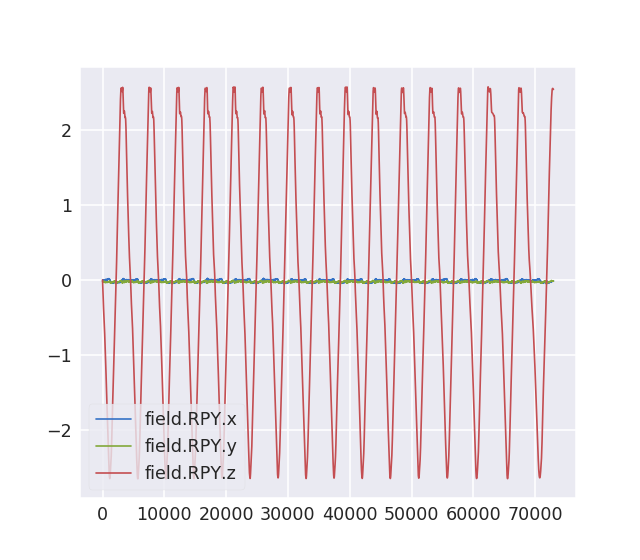

In [18]:
i=0
for i in range(len(yawAngles)):
    if yawAngles[i] > 180:
        yawAngles[i] = yawAngles[i] - 360

gtNew['field.RPY.z'] = yawAngles

gtNew = gtNew * 3.1415/180
gtNew.plot()

In [19]:
gtNew.describe()

,field.RPY.x,field.RPY.y,field.RPY.z
count,72971.000000,72971.000000,72971.000000
mean,-0.011869,-0.025510,0.105162
std,0.015267,0.007885,1.707926
min,-0.042035,-0.050006,-2.658131
25%,-0.027257,-0.031036,-1.368752
50%,-0.007014,-0.024491,0.063158
75%,0.000390,-0.020287,1.839805
max,0.021024,-0.006867,2.582195


### PixHawk Data

#### EDA

In [176]:
pix_rpy_df = pd.read_csv('./aug22/rpy_pix_df.csv')
pix_rpy_df.head()

,field.RPY.x,field.RPY.y,field.RPY.z
0,6.083499,-4.776486,-29.999507
1,6.080434,-4.765716,-29.909368
2,6.073234,-4.751528,-29.829520
3,6.061122,-4.731960,-29.727047
4,6.044819,-4.718991,-29.629371


In [177]:
pix_rpy_df *= 3.1415/180

<IPython.core.display.Javascript object>


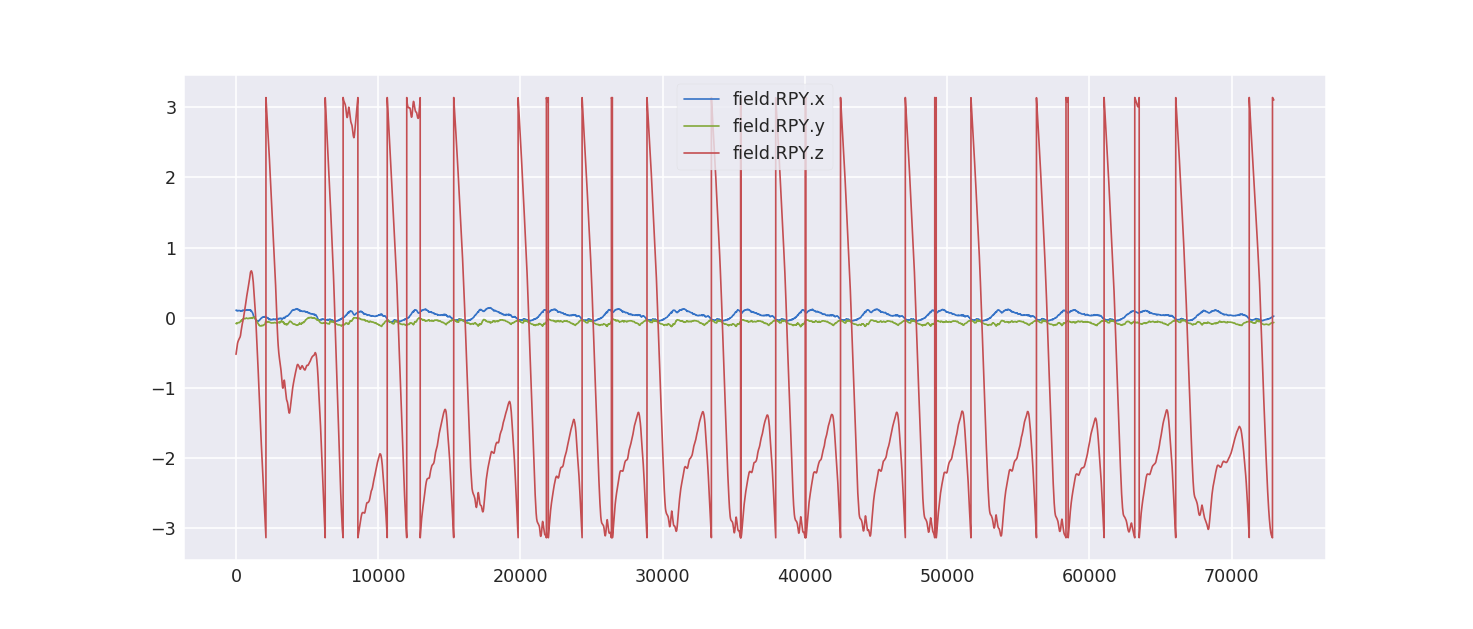

In [179]:
pix_rpy_df.plot()

In [178]:
pix_rpy_df.describe()

,field.RPY.x,field.RPY.y,field.RPY.z
count,72975.000000,72975.000000,72975.000000
mean,0.031176,-0.067010,-1.205325
std,0.051215,0.024186,1.802846
min,-0.065910,-0.129926,-3.141578
25%,-0.021490,-0.086237,-2.500647
50%,0.033414,-0.064750,-1.871622
75%,0.076274,-0.049876,-0.525340
max,0.142145,0.009871,3.141587


<IPython.core.display.Javascript object>


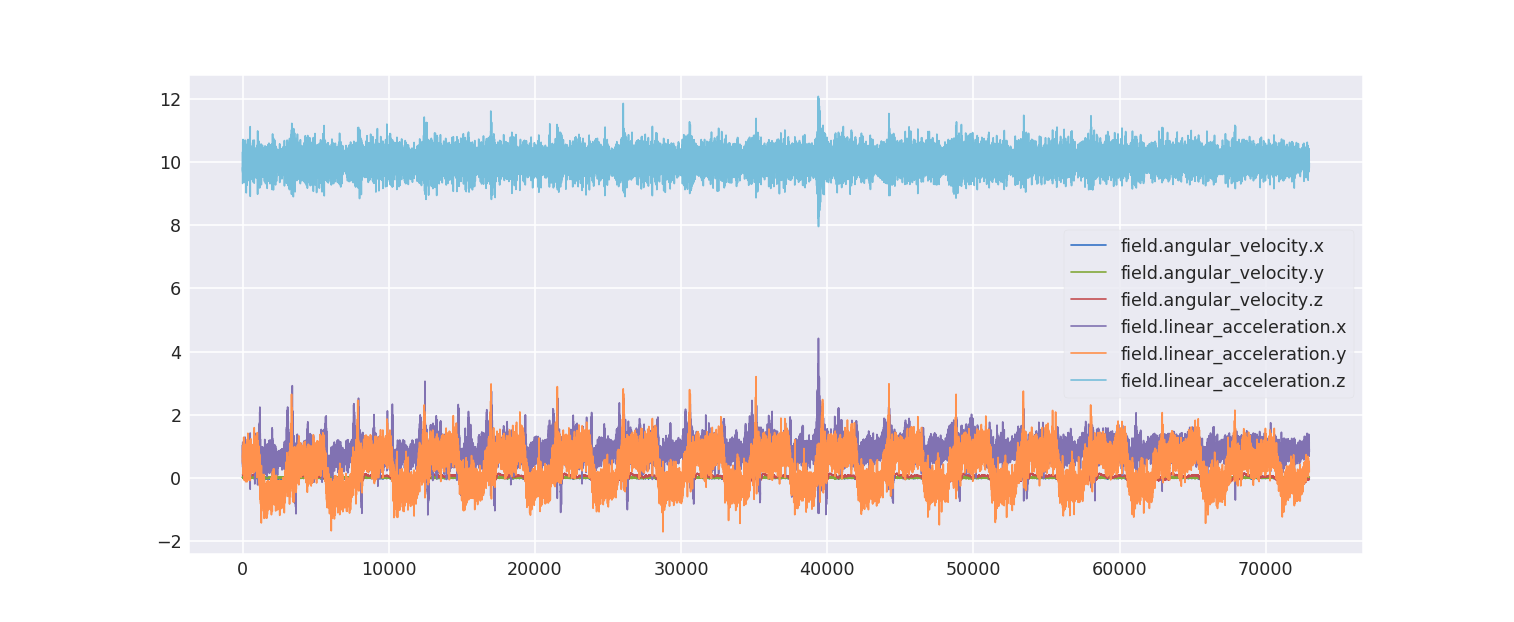

In [180]:
pix_raw_df = pd.read_csv('./aug22/aug22_pix.csv')
pix_raw_df = pix_raw_df[['field.angular_velocity.x', 'field.angular_velocity.y', 'field.angular_velocity.z', 
                      'field.linear_acceleration.x', 'field.linear_acceleration.y', 'field.linear_acceleration.z']]

pix_raw_df.plot()

In [181]:
pix_raw_df.describe()

,field.angular_velocity.x,field.angular_velocity.y,field.angular_velocity.z,field.linear_acceleration.x,field.linear_acceleration.y,field.linear_acceleration.z
count,72975.000000,72975.000000,72975.000000,72975.000000,72975.000000,72975.000000
mean,-0.004025,0.003087,-0.070466,0.834744,0.333797,10.036104
std,0.015722,0.012707,0.127659,0.320392,0.559977,0.265030
min,-0.089597,-0.082006,-0.291121,-1.179224,-1.715936,7.962973
25%,-0.014413,-0.004351,-0.212621,0.666405,-0.165039,9.869870
50%,-0.003886,0.002914,-0.049850,0.832261,0.413714,10.035275
75%,0.006345,0.010393,0.050263,1.009138,0.787426,10.201483
max,0.078753,0.093071,0.143536,4.417985,3.203163,12.088557


#### Functions

In [120]:
def load_dataframes(rpy_path, raw_path):
    pix_rpy_df = pd.read_csv(rpy_path)
    pix_rpy_df = pix_rpy_df[['field.RPY.x', 'field.RPY.y', 'field.RPY.z']]
    pix_rpy_df *= 3.1415/180
    
    pix_raw_df = pd.read_csv(raw_path)
    pix_raw_df = pix_raw_df[['field.angular_velocity.x', 'field.angular_velocity.y', 'field.angular_velocity.z', 
                      'field.linear_acceleration.x', 'field.linear_acceleration.y', 'field.linear_acceleration.z']]
    
    pix_raw_df.dropna(how='any', inplace=True)
    pix_rpy_df.dropna(how='any', inplace=True)
    
    ip_len =  pix_raw_df.shape[0]
    op_len = pix_rpy_df.shape[0]
    if ip_len != op_len:
        min_len = min(ip_len, op_len)
        pix_raw_df = pix_raw_df[:min_len]
        pix_rpy_df = pix_rpy_df[:min_len]
        print("Shape of raw_df is {} and shape of rpy_df is {}. Truncating to minimum...".format(ip_len, op_len))
    
    return pix_rpy_df, pix_raw_df

In [70]:
def _create_dataset(datasetInput, datasetOutput, look_back=1):
    X, y = deque(), deque()
    samples = len(datasetInput) - look_back - 1
    for i in range(look_back, samples):
        a = datasetInput[(i - look_back): i+1, :]
        X.append(a)
        y.append(datasetOutput[i , :])
    
    return np.array(X), np.array(y)

In [100]:
def get_train_test_split(samples=20000, split=0.8, raw_df=None, rpy_df=None, x_scaler=None, look_back=15, lag_one=True):
    train_size = int(samples * split)
    test_size = samples - train_size
    
    input_slice = raw_df[:samples]
    output_slice = rpy_df[:samples]
    
    if lag_one:
        feedback_df = output_slice.shift(1, axis=0)
        input_slice = np.hstack((input_slice.values, feedback_df.values))
#         input_slice = pd.DataFrame(data=input_slice, columns=input_slice.columns.tolist() + feedback_df.columns.tolist(), copy=True)
        input_slice = input_slice[1:]
        output_slice = output_slice[1:]

    x_scaler.fit(input_slice)

    input_slice = x_scaler.transform(input_slice)
    output_slice /= 3.1415
    
    train_inp_slice = input_slice[:train_size]
    train_op_slice = output_slice[:train_size]

    test_inp_slice = input_slice[train_size:]
    test_op_slice = output_slice[train_size:]
    
    look_back = look_back
    train_X, train_y = _create_dataset(train_inp_slice, train_op_slice.values, look_back)
    test_X, test_y = _create_dataset(test_inp_slice, test_op_slice.values, look_back)
    
#     train_X = np.moveaxis(train_X, 1, -1)
#     test_X = np.moveaxis(test_X, 1, -1)
    
    print("Data shapes: train inp: {}, train op: {}, test inp: {}, test op: {}".format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))
    
    return train_X, train_y, test_X, test_y

In [96]:
def get_model(rec_unit, timesteps, on_gpu=False, input_shape=None):
    inp = Input(shape=input_shape, name="input")
    x = _get_recurrent_unit(recurrent_unit=rec_unit[0].rec_type, bidirectional=rec_unit[0].bidirectional,
                            return_seq=rec_unit[0].ret_seq, units=rec_unit[0].units, 
                            unroll=rec_unit[0].unroll, activation=rec_unit[0].activation, on_gpu=on_gpu)(inp)
    x = BatchNormalization()(x)
    x = _get_recurrent_unit(recurrent_unit=rec_unit[1].rec_type, bidirectional=rec_unit[1].bidirectional,
                            return_seq=rec_unit[1].ret_seq, units=rec_unit[1].units, 
                            unroll=rec_unit[1].unroll, activation=rec_unit[1].activation, on_gpu=on_gpu)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation="relu", kernel_regularizer="l2")(x)
    x = BatchNormalization()(x)
    op1 = Dense(32, activation="relu", kernel_regularizer="l2")(x)
    op1 = Dense(1, activation="tanh", name="roll")(op1)
    op2 = Dense(32, activation="relu", kernel_regularizer="l2")(x)
    op2 = Dense(1, activation="tanh", name="pitch")(op2)
    op3 = Dense(32, activation="relu", kernel_regularizer="l2")(x)
    op3 = Dense(1, activation="tanh", name="yaw")(op3)
    model = Model(inputs=inp, outputs=[op1, op2, op3])

#     model.summary()
    
    return model

In [73]:
def _get_recurrent_unit(recurrent_unit="gru", bidirectional=False, units=32, unroll=False, return_seq=False, activation="relu", dropout=0.1, rec_dropout=0.2, on_gpu=False):
    x = None
    kernel_initialise = "he_normal" if activation == "relu" else "glorot_normal"    
    if recurrent_unit == "gru":
        x = GRU(units, activation=activation, dropout=dropout, recurrent_dropout=rec_dropout, return_sequences=return_seq, unroll=unroll, kernel_initializer=kernel_initialise) \
        if not on_gpu else CuDNNGRU(units, return_sequences=return_seq, kernel_regularizer="l2")
    elif recurrent_unit == "lstm":
        x = LSTM(units, activation=activation, dropout=dropout, recurrent_dropout=rec_dropout, return_sequences=return_seq, unroll=unroll, kernel_initializer=kernel_initialise) \
        if not on_gpu else CuDNNLSTM(units, return_sequences=return_seq, kernel_regularizer="l2")
    else: 
        raise ValueError("Recurrent unit should be either 'gru' or 'lstm'.")
            
    if bidirectional:
        x = Bidirectional(x)
        
    return x

In [74]:
def setup_callbacks(directory, config_id):
    logdir = os.path.join(directory, "logs", config_id)
    callbacks = []
    callbacks.append(EarlyStopping(min_delta=0.0001, patience=25, verbose=2, restore_best_weights=True))
    callbacks.append(TensorBoard(log_dir=logdir))
                          
    return callbacks

In [75]:
def get_prediction_and_scores(model, train_X, train_y, test_X, test_y):
    train_preds = model.predict(train_X)
    test_preds = model.predict(test_X)
    
    train_preds = np.hstack((preds for preds in train_preds))
    test_preds = np.hstack((preds for preds in test_preds))
    
    train_preds *= 3.1415
    train_y *= 3.1415 
    test_preds *= 3.1415
    test_y *= 3.1415 
    
    train_score = (mean_squared_error(train_y, train_preds, multioutput="raw_values"))
    test_score = (mean_squared_error(test_y, test_preds, multioutput="raw_values"))
    
    print('Train Score: {} MSE'.format(train_score))
    print('Test Score: {} MSE'.format(test_score))
    
    return train_preds, test_preds, train_score, test_score

In [146]:
def save_model_and_plot(directory, model, train_preds, test_preds, pix_rpy_df, look_back, samples):
    
    save_path = os.path.join(directory, "model")
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    # save model
    model_json = model.to_json()
    with open(os.path.join(save_path, "model.json"), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(os.path.join(save_path, "model.h5"))
    print("Saved model to disk")
    
    # save plot
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
    plt.ioff()
    for i, (ax, title) in enumerate(zip(axes, ["Roll", "Pitch", "Yaw"])):
        ax.plot(np.vstack((train_preds, test_preds))[:, i], label="Train")
        ax.plot(train_preds[:, i], label="Test")
        ax.plot(rpy_df.values[15: samples, i], "yellow", label="Ground Truth")
        ax.legend()
        ax.set_ylabel(title)

    plt.xlabel("Timesteps")
    plt.rcParams['figure.figsize'] = [16, 20]
    plt.savefig(os.path.join(save_path, "pred_gt_plot.png"))
    print("Saved plot to disk")
    plt.close()

    # save plot
    plot_model(model, show_shapes=True, to_file=os.path.join(save_path, "model.png"))


In [77]:
def save_to_results(directory, content, mode="w"):
    with open(os.path.join(directory, "results.json"), mode) as f:
        f.write(content)

#### Configurations

In [78]:
on_gpu = False
root_path = "/media/ankurrc/new_volume/usl/LSTMIMU/"
# root_path = '/gdrive/My Drive/Colab Notebooks/LSTMIMU'

In [79]:
# named tuples
Configuration = namedtuple("Configuration", ['look_back', 'activation', 'rec_type', 'bidirectional', 'dropout', 'rec_dropout'])
RecurrentUnit = namedtuple("RecurrentUnit", ['rec_type', 'bidirectional', 'ret_seq', 'units', 'unroll', 'activation', 'dropout', 'rec_dropout'])

In [109]:
dataset_path = os.path.join(root_path, "dataset", "aug22")
rpy_data_path = os.path.join(dataset_path, "vectornav.csv")
# rpy_data_path = os.path.join(dataset_path, "rpy_pix_df.csv")
raw_data_path = os.path.join(dataset_path, "aug22_pix.csv")
experiments_path = os.path.join(root_path, "experiments")

In [122]:
samples = 70000
split = 0.8
scalerX = MinMaxScaler(feature_range=(0, 1))

In [143]:
## config space
lag_one = True
look_backs = [127, 255] if on_gpu else [7]
activations = [None] if on_gpu else ["tanh"]
rec_types = ["gru"]
bidirectionals = [False]
dropouts = [None] if on_gpu else [0.2]
rec_dropouts = [None] if on_gpu else [0.2]

In [144]:
i_configs = product(look_backs, activations, rec_types, bidirectionals, dropouts, rec_dropouts)
configs = [config for config in i_configs]
epochs = 250
batch_size = 64 if on_gpu else 32 
verbosity=1

In [145]:
configs

[(7, 'tanh', 'gru', False, 0.2, 0.2)]

### Script

In [149]:
# get the dataframes
rpy_df, raw_df = load_dataframes(rpy_data_path, raw_data_path)

best_mse = np.Inf
best_config = -1
results = {}
timestamp = str(time())
current_experiment_dir = datetime.datetime.fromtimestamp(int(timestamp.split(".")[0])).strftime('%Y_%m_%d-%H_%M_%S')
current_experiment_path = os.path.join(experiments_path, current_experiment_dir)

tqdm_bar = tqdm(total=len(configs))

# save_to_results(current_experiment_path, json.dumps({"comment": "Started at {}...".format(current_experiment_dir)}), "w")
for i, config in enumerate(configs):
    print("-"*60, "Started {}/{}".format(i+1, len(configs)), "-"*60)
    config_id = str(i+1)
    config = Configuration(*config)
    timesteps = config.look_back + 1
    print(config)
    
    # generate the train-test split
    train_X, train_y, test_X, test_y = get_train_test_split(samples=samples, split=split, raw_df=raw_df, rpy_df=rpy_df, x_scaler=scalerX, look_back=config.look_back, lag_one=lag_one)
    # formulate the recurrent units
    recurrent_units = [RecurrentUnit(config.rec_type, config.bidirectional, True, 32, True, config.activation, config.dropout, config.rec_dropout),
                       RecurrentUnit(config.rec_type, config.bidirectional, False, 64, True, config.activation, config.dropout, config.rec_dropout)]
    # clear previous session and build model graph
    K.clear_session()
    model = get_model(recurrent_units, timesteps, on_gpu=on_gpu, input_shape=train_X.shape[1:])
#     model.summary()
    # setup callbacks
    callbacks = setup_callbacks(current_experiment_path, config_id)
    # compile graph
    model.compile(Adam(), loss='mse', metrics=["mae"], loss_weights=[1, 1, 1])
    # start training
    model.fit(train_X, [train_y[:, 0], train_y[:, 1], train_y[:, 2]], epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=verbosity, shuffle=True, callbacks=callbacks)
    # get prediction scores
    train_preds, test_preds, train_score, test_score =  get_prediction_and_scores(model, train_X, train_y, test_X, test_y)
    # save if required
    if test_score[2] < best_mse:
        best_mse = test_score[2]
        save_model_and_plot(current_experiment_path, model, train_preds, test_preds, rpy_df, config.look_back, samples)
        best_config = i+1
    result = {"config":str(config), "test_score": test_score.tolist(),"train_score": train_score.tolist(),"yaw_mse": test_score[2]}
    comment = "Currently, the best config is {} with an MSE of {} for 'YAW'.".format(best_config, best_mse)
    results[config_id] = result
    print(comment)
    print("-"*60, "Ended {}/{}".format(i+1, len(configs)), "-"*60)
    save_to_results(current_experiment_path, "\n" + json.dumps([result, {"comment": comment}]), "a")
    tqdm_bar.update()
    
final_line = "Best config was {} with an MSE of {} for 'YAW'.".format(best_config, best_mse)
save_to_results(current_experiment_path, json.dumps([results, {"comment": final_line}]), "w")
print(final_line)


  0%|          | 0/1 [00:00<?, ?it/s]

Shape of raw_df is 72975 and shape of rpy_df is 72971. Truncating to minimum...
------------------------------------------------------------ Started 1/1 ------------------------------------------------------------
Configuration(look_back=7, activation='tanh', rec_type='gru', bidirectional=False, dropout=0.2, rec_dropout=0.2)


Data shapes: train inp: (55985, 8, 9), train op: (55985, 3), test inp: (13984, 8, 9), test op: (13984, 3)
Train on 44788 samples, validate on 11197 samples
Epoch 1/250
44788/44788 [==============================] - 22s 495us/step - loss: 0.6217 - roll_loss: 0.0119 - pitch_loss: 0.0142 - yaw_loss: 0.0825 - roll_mean_absolute_error: 0.0494 - pitch_mean_absolute_error: 0.0564 - yaw_mean_absolute_error: 0.1878 - val_loss: 0.0639 - val_roll_loss: 2.0248e-05 - val_pitch_loss: 7.8858e-06 - val_yaw_loss: 0.0391 - val_roll_mean_absolute_error: 0.0036 - val_pitch_mean_absolute_error: 0.0023 - val_yaw_mean_absolute_error: 0.1624
Epoch 2/250
44788/44788 [==============================] - 16s 362us/step - loss: 0.0429 - roll_loss: 9.2379e-06 - pitch_loss: 7.0312e-06 - yaw_loss: 0.0330 - roll_mean_absolute_error: 0.0022 - pitch_mean_absolute_error: 0.0018 - yaw_mean_absolute_error: 0.1219 - val_loss: 0.0346 - val_roll_loss: 3.4082e-06 - val_pitch_loss: 1.5145e-06 - val_yaw_loss: 0.0287 - val_roll_me

Epoch 18/250
44788/44788 [==============================] - 16s 364us/step - loss: 0.0069 - roll_loss: 2.3916e-05 - pitch_loss: 6.5954e-06 - yaw_loss: 0.0058 - roll_mean_absolute_error: 0.0044 - pitch_mean_absolute_error: 0.0021 - yaw_mean_absolute_error: 0.0425 - val_loss: 0.0148 - val_roll_loss: 2.2100e-05 - val_pitch_loss: 5.7655e-06 - val_yaw_loss: 0.0137 - val_roll_mean_absolute_error: 0.0041 - val_pitch_mean_absolute_error: 0.0020 - val_yaw_mean_absolute_error: 0.0837
Epoch 19/250
44788/44788 [==============================] - 15s 328us/step - loss: 0.0067 - roll_loss: 2.3976e-05 - pitch_loss: 6.5791e-06 - yaw_loss: 0.0058 - roll_mean_absolute_error: 0.0044 - pitch_mean_absolute_error: 0.0021 - yaw_mean_absolute_error: 0.0411 - val_loss: 0.0144 - val_roll_loss: 2.1738e-05 - val_pitch_loss: 5.9380e-06 - val_yaw_loss: 0.0135 - val_roll_mean_absolute_error: 0.0040 - val_pitch_mean_absolute_error: 0.0020 - val_yaw_mean_absolute_error: 0.0861
Epoch 20/250
44788/44788 [================

100%|██████████| 1/1 [08:05<00:00, 485.41s/it]

Currently, the best config is 1 with an MSE of 0.04102333778903645 for 'YAW'.
------------------------------------------------------------ Ended 1/1 ------------------------------------------------------------
Best config was 1 with an MSE of 0.04102333778903645 for 'YAW'.


In [127]:
train_preds, test_preds, train_score, test_score =  get_prediction_and_scores(model, train_X, train_y, test_X, test_y)

Train Score: [2.75094076e-03 3.57124230e-03 1.53027943e+01] MSE
Test Score: [2.59270048e-03 3.79675937e-03 1.33911370e+01] MSE


In [142]:

plt.savefig("abc.png")